In this notebook, we explore color refinement in SBMs

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.cuda
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from itertools import permutations,combinations,combinations_with_replacement

We begin by implementing our SBMs

In [2]:
def generate_SBM(n,connection_matrix,edge_possibility,class_possibility):
    """This creates a random graph based on:
        n : how many node we have
        connection_matrix : the likelihood of a node in cluster i connecting to a node in cluster j
        edge_possibility : the likelihood of an edge existing between two nodes
        class_possibility : the likelihood of belonging to any given class"""
    num_clusters = len(class_possibility)
    cluster_assignments = np.sort(np.random.choice(np.arange(num_clusters),p=class_possibility,size=n))
    cluster_indices = [cluster_assignments == a for a in range(num_clusters)]
    cluster_assignments = np.expand_dims(cluster_assignments,1)
    #clusters = cluster_assignments == cluster_assignments.T
    probabilities = np.random.random((n,n))
    adj = np.zeros((n,n))
    for i in range(num_clusters):

        for j in range(num_clusters):
            mask = np.zeros((n,n),dtype=bool)
            imask = np.zeros((n,n))
            imask[cluster_indices[i]] = ~mask[cluster_indices[i]]
            if(len(cluster_indices[i]) !=0 and len(cluster_indices[j]) != 0):
                jmask = np.zeros((n,n))
                jmask[:,cluster_indices[j]] =  ~mask[:,cluster_indices[j]]
                total_mask = jmask*imask
                probs = probabilities

                probs = probs < (connection_matrix[i,j]*edge_possibility)
                #print(probs)
                probs = (total_mask*1)*probs
                #print(probs)
                adj += probs
    tri = np.tri((n),k=-1)
    adj = adj* tri
    adj += adj.T
    #print(cluster_assignments)
    return adj,cluster_assignments

def generate_SSBM(n,c,p_intra,p_inter):
    """This is similar to the above SBM but in this case it is symmetric"""
    # assign a community to each node
    community = np.repeat(list(range(c)),np.ceil(n/c))
    
    #np.repeat(list to iterate over, how many times to repeat an item)

    #make sure community has size n
    community = community[0:n]
    communities = community.copy()
    # just in case repeat repeated too many

    # make it a collumn vector
    community = np.expand_dims(community,1)

    # generate a boolean matrix indicating whether 
    # two nodes share a community
    # this is a smart way to generate a section graph
    intra = community == community.T
    inter = community != community.T# we can also use np.logical not

    random = np.random.random((n,n))
    tri = np.tri(n,k=-1).astype(bool)

    intergraph = (random < p_intra) * intra * tri# this creates a matrix that only has trues where
                                                # random< p_intra, they are in intra, and along half the matrix
                                                # (if it were the whole matrix it would be double the edges we want)
    intragraph = (random < p_inter) * inter * tri# same thing here
    graph = np.logical_or(intergraph,intragraph)
    graph = graph*1# this converts it to a int tensor
    graph += graph.T
    return graph,communities


def generate_cSBM(d,lamb,mu,num_features,num_nodes,num_classes):
    c_in = d+lamb*np.sqrt(d) # c_in/c_out as described in the equations
    c_out = d-lamb*np.sqrt(d) 
    p_in = c_in/num_nodes # compiles these to pass into the SSBM
    p_out = c_out/num_nodes
    
    adj, communities = generate_SSBM(num_nodes,num_classes,p_in,p_out) # obtains the graph structure
    u = np.random.normal(0,1/num_features,(num_features)) # obtains the random normal vector u
    Z = np.random.normal(0,.2,(num_nodes,num_features)) # obtains the random noise vector i presume
    v = communities # puts the groups into a format for the equations
 
    perms = generate_perms_rand(num_classes,num_features)
    
    b = np.zeros((num_nodes,num_features))
    for i in range(num_nodes):
        b[i] = np.sqrt(mu/num_nodes)*(np.diag(perms[v[i]])@u) + Z[i]/np.sqrt(num_features)
    return adj,b,communities

Now we implement Weisfeiler-Leman color refinement algorithm to obtain Coarsest Equitable Partitions (CEPs)

In [3]:
def weisfeiler_leman_partition(G):
    steps = 0
    
    num_nodes = len(G.nodes)
    node_colors = np.ones(num_nodes, dtype=np.int32)
    partition = {frozenset(G.nodes)}
    
    while True:
        #aggregate colors, one node at a time
        #print(partition)
        neighbor_colors = [tuple(sorted(node_colors[list(G.neighbors(i))])) for i in range(num_nodes)]     
        
        new_colors = np.array([hash(neighbor_colors[i]) for i in range(num_nodes)])
        new_colors_unique = list(set(new_colors))
        
        new_partition = {frozenset(np.where(new_colors == new_colors_unique[i])[0]) 
                         for i in range(len(new_colors_unique))}
        
        if new_partition == partition:
            print(f"Process stabilized after {steps} steps on a partition with {len(partition)} cells")
            break
        
        steps += 1
        partition = new_partition
        node_colors = new_colors
    
    partition_list = [list(list(partition)[i]) for i in range(len(partition))]
    partition_dict = {}

    for cell_id, cell_list in enumerate(partition_list):
        for node in cell_list:
            partition_dict[node] = cell_id

    partition_id_list = [partition_dict[i] for i in range(len(G.nodes))]
    num_cells = len(partition_list)
    
    return partition_id_list, len(partition_list), steps

Now we test the algorithm on random graphs

Process stabilized after 4 steps on a partition with 30 cells


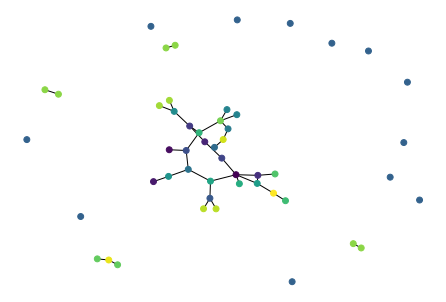

In [4]:
G = nx.gnm_random_graph(50,35)
partition, _, _ = weisfeiler_leman_partition(G);
nx.draw(G, node_size=35, node_color=partition, edge_color="black")

Let's test on Stochastic Blockmodels

Process stabilized after 6 steps on a partition with 251 cells


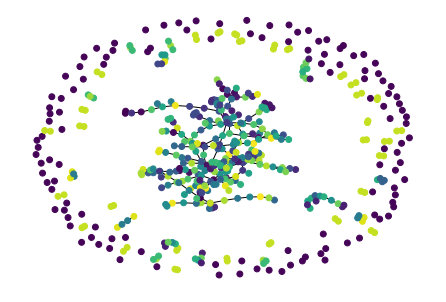

In [5]:
nodes = 500
adj, labels = generate_SSBM(nodes, 2, 2.5/nodes, 0.1/nodes)
G = nx.from_numpy_array(adj)
partition, _, _ = weisfeiler_leman_partition(G);
nx.draw(G, node_size=35, node_color=partition, edge_color="black")

Let's see how the # of cells in the partition varies with statistics like density, etc

In [6]:
n_min = 50
n_max = 2000

nodes_vs_cells_data = np.array([])

for num_nodes in range(n_min, n_max+1, 5):
    adj, labels = generate_SSBM(num_nodes, 2, 2.5/num_nodes, 0.1/num_nodes)
    G = nx.from_numpy_array(adj)
    partition, num_cells, num_steps = weisfeiler_leman_partition(G)
    
    num_edges = len(G.edges)
    num_components = len(list(nx.connected_components(G)))
    size_largest_component = max([len(comp) for comp in list(nx.connected_components(G))])
    
    row_data = np.array([num_nodes, num_edges, num_cells, num_steps, num_components, size_largest_component])
    nodes_vs_cells_data = np.append(nodes_vs_cells_data, row_data)

Process stabilized after 4 steps on a partition with 21 cells
Process stabilized after 4 steps on a partition with 20 cells
Process stabilized after 5 steps on a partition with 34 cells
Process stabilized after 4 steps on a partition with 26 cells
Process stabilized after 5 steps on a partition with 30 cells
Process stabilized after 5 steps on a partition with 37 cells
Process stabilized after 4 steps on a partition with 50 cells
Process stabilized after 5 steps on a partition with 50 cells
Process stabilized after 4 steps on a partition with 38 cells
Process stabilized after 4 steps on a partition with 55 cells
Process stabilized after 6 steps on a partition with 41 cells
Process stabilized after 6 steps on a partition with 47 cells
Process stabilized after 4 steps on a partition with 58 cells
Process stabilized after 4 steps on a partition with 56 cells
Process stabilized after 4 steps on a partition with 68 cells
Process stabilized after 5 steps on a partition with 72 cells
Process 

Process stabilized after 6 steps on a partition with 351 cells
Process stabilized after 7 steps on a partition with 345 cells
Process stabilized after 9 steps on a partition with 367 cells
Process stabilized after 8 steps on a partition with 343 cells
Process stabilized after 7 steps on a partition with 347 cells
Process stabilized after 7 steps on a partition with 367 cells
Process stabilized after 8 steps on a partition with 357 cells
Process stabilized after 7 steps on a partition with 396 cells
Process stabilized after 8 steps on a partition with 371 cells
Process stabilized after 8 steps on a partition with 383 cells
Process stabilized after 7 steps on a partition with 413 cells
Process stabilized after 8 steps on a partition with 370 cells
Process stabilized after 8 steps on a partition with 373 cells
Process stabilized after 8 steps on a partition with 398 cells
Process stabilized after 8 steps on a partition with 338 cells
Process stabilized after 6 steps on a partition with 31

Process stabilized after 7 steps on a partition with 702 cells
Process stabilized after 8 steps on a partition with 679 cells
Process stabilized after 8 steps on a partition with 701 cells
Process stabilized after 8 steps on a partition with 658 cells
Process stabilized after 8 steps on a partition with 677 cells
Process stabilized after 9 steps on a partition with 699 cells
Process stabilized after 8 steps on a partition with 658 cells
Process stabilized after 7 steps on a partition with 654 cells
Process stabilized after 9 steps on a partition with 609 cells
Process stabilized after 7 steps on a partition with 630 cells
Process stabilized after 7 steps on a partition with 677 cells
Process stabilized after 9 steps on a partition with 673 cells
Process stabilized after 9 steps on a partition with 781 cells
Process stabilized after 8 steps on a partition with 628 cells
Process stabilized after 8 steps on a partition with 701 cells
Process stabilized after 9 steps on a partition with 69

In [7]:
data = nodes_vs_cells_data.reshape((-1, 6))
data_int = data.astype(np.int32)

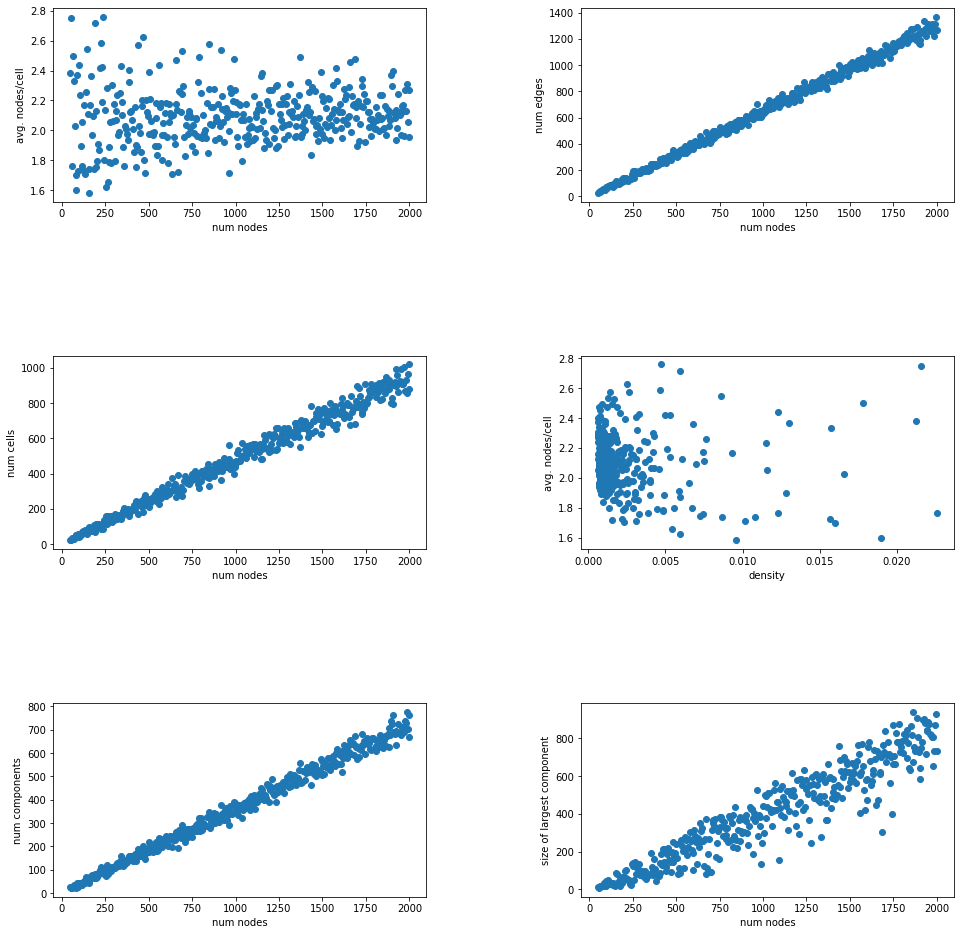

In [8]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3,2)

avg_nodes_per_cell = data[:,0]/data[:,2]
density = data[:, 1] / (data[:, 0]*(data[:, 0]-np.ones(len(data[:, 0])))/2)

axes[0,0].scatter(x=data[:, 0], y=avg_nodes_per_cell)
axes[0,0].set_xlabel('num nodes')
axes[0,0].set_ylabel('avg. nodes/cell')

axes[0,1].scatter(x=data[:,0], y=data[:,1])
axes[0,1].set_xlabel('num nodes')
axes[0,1].set_ylabel('num edges')

axes[1,0].scatter(x=data[:,0], y=data[:,2])
axes[1,0].set_xlabel('num nodes')
axes[1,0].set_ylabel('num cells')

axes[1,1].scatter(x=density, y=avg_nodes_per_cell)
axes[1,1].set_xlabel('density')
axes[1,1].set_ylabel('avg. nodes/cell')

axes[2,0].scatter(x=data[:,0], y=data[:,4])
axes[2,0].set_xlabel('num nodes')
axes[2,0].set_ylabel('num components')

axes[2,1].scatter(x=data[:,0], y=data[:,5])
axes[2,1].set_xlabel('num nodes')
axes[2,1].set_ylabel('size of largest component')

fig.tight_layout(pad=1)
fig.set_size_inches(15,15)
plt.show()

In [9]:
#np.savetxt('num_nodes_vs_partition_size/num_nodes_vs_partition_size_###.csv', data_int, delimiter=',')

Can we use these partitions to coarsen the graph? What is the relationship between nodes within partitions? Are they interchangeable amongst themselves?

Train GNN on CEP-averaged real world data? How many edge swaps are possible before you leave the class? Diameter of the WL-equivalence classes? How often do partition cells have uniform class identity in the SBM?

1. Try partition averaging vs. GNN performance

2. Understand real-world CEP's

In [10]:
from torch_geometric.datasets import Planetoid
data = Planetoid(root="./data", name="Cora")[0]
edgelist = data['edge_index']
edgelist.transpose_(1,0)
edgelist = edgelist.numpy()

G_data = nx.from_edgelist(edgelist)

data_CEP, _, _ = weisfeiler_leman_partition(G_data)

Process stabilized after 5 steps on a partition with 2365 cells


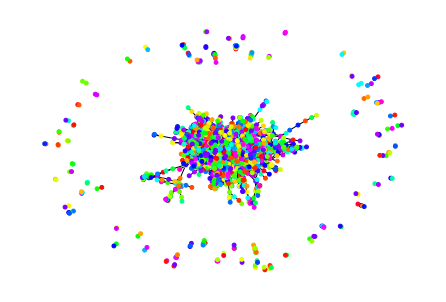

In [11]:
nx.draw(G_data, node_color=data_CEP, node_size=15, cmap=cm.get_cmap('gist_rainbow'))

let's see if naively CEP smoothing the features improves GCN's performance from the baseline

In [12]:
def avg_features_over_partition(features, partition):
    partition_np = np.array(partition, dtype=np.int32)
    new_feats=features
    for cell in np.unique(partition_np):
        cell_nodes = np.where(partition_np == cell)
        cell_average_feature = features[cell_nodes].mean(dim=0)
        for node in cell_nodes:
            new_feats[node]=cell_average_feature
            
    return new_feats

In [13]:
#code sampled from Drake's implementation of GCN
from torch_geometric.nn import GCNConv,GATConv
import torch.nn as nn
import torch.nn.functional as F

class GCN(torch.nn.Module):# this is the torch geometric implementation of our GCN model like before, it
    # is a lot simpler to implement and way customizeable
    def __init__(self, in_feat, hid_feat, out_feat):
        super().__init__()
        self.conv1 = GCNConv(in_feat, hid_feat)
        self.convh = GCNConv(hid_feat,hid_feat)# adding an extra hidden layer essentially solves exact recovery
        # the size of the hidden layers just have to be greater than or equal to the size of the output layer
        self.conv2 = GCNConv(hid_feat, out_feat)
        self.activation = nn.ReLU()
        #self.dropout = nn.Dropout(p=.4)

    def forward(self, x, edge_index):
        x = self.activation(self.conv1(x, edge_index))
        x = F.dropout(x, training= self.training)
        x = self.activation(self.convh(x,edge_index))
        x = F.dropout(x,training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x,dim=1)
    
def accuracy(preds,mask):# obtains the accuracy of the model
    correct = (preds[mask] == labels[mask]).sum()
    acc = int(correct)/int(mask.sum())
    return acc


num_nodes = len(G_data.nodes())
num_features = data.x.size()[1]
num_classes = data.y.unique().size()[0]


# model hyperparameters
hidden_layers = 10
lr = .01
epochs = 200

model = GCN(num_features,hidden_layers,num_classes)
optimizer = torch.optim.Adam(params=model.parameters(),lr = lr)

# creates some masks so we have stuff for training and validation
train_mask = data.train_mask
val_mask = data.val_mask

# turns all of our tensors into the desired format
edge_list = data['edge_index'].transpose(1,0)
b = data.x
labels = data.y

epoch: 0 training_loss: 1.9450020790100098 training_acc: 0.14285714285714285 val_loss: 1.9434207677841187 val_acc: 0.116
epoch: 100 training_loss: 0.16113366186618805 training_acc: 0.9571428571428572 val_loss: 1.6623594760894775 val_acc: 0.672
0.7658788774002954


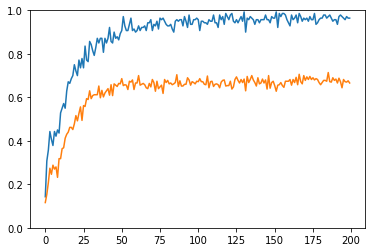

In [14]:
model.train()# tells our model we are about to train
losses = []
accs = []

for epoch in range(epochs):# runs through all the data 200 times
    optimizer.zero_grad()
    out = model(b, edge_list)

    train_loss = F.nll_loss(out[train_mask], labels[train_mask])
    train_acc = accuracy(out.max(1)[1], train_mask)

    val_loss = F.nll_loss(out[val_mask], labels[val_mask])
    val_acc = accuracy(out.max(1)[1], val_mask)
    losses.append([train_loss.item(),val_loss.item()])
    accs.append([train_acc,val_acc])
    
    if(epoch % 100 == 0):
        print("epoch: {} training_loss: {} training_acc: {} val_loss: {} val_acc: {}".format(epoch,train_loss,train_acc,val_loss, val_acc))
        
    train_loss.backward()
    optimizer.step()

losses = np.array(losses)
accs = np.array(accs)
plt.plot(accs[:,0])
plt.plot(accs[:,1])
plt.ylim(0,1)

model.eval()
out = model(b,edge_list)
test_acc = accuracy(out.max(1)[1],torch.ones(num_nodes).to(torch.bool))
print(test_acc)

Well, feature smoothing over the CEP didn't particularly help or hinder GCN

In [15]:
#idea--what if we learn a partition that helps performance
#this could result in aggregation not over neighbors, but over points of symmetry

Let's try to see what changes with the scrambling of edges

In [16]:
#courtesy of Drake
def scramble_edges(edge_list, labels, ids, num_classes,dataset):
    data = dataset[0]
    edge_df = pd.DataFrame(edge_list.numpy().T)
    np_edge_data = edge_list.numpy().T
    labels = labels.numpy()
    ids = ids.numpy()
    for start_group in range(dataset.num_classes):
        id_mask = labels == start_group
        start_ids = ids[id_mask]
        
        for end_group in range(start_group,dataset.num_classes):
            id_mask = labels == end_group
            end_ids = ids[id_mask]

            start_mask_1 = edge_df[0].isin(start_ids)
            end_mask_1 = edge_df[1].isin(end_ids)
            total_mask_1 = np.logical_and(start_mask_1,end_mask_1)
            start_mask_2 = edge_df[1].isin(start_ids)
            end_mask_2 = edge_df[0].isin(end_ids)
            total_mask_2 = np.logical_and(start_mask_2,end_mask_2)
            total_mask = np.logical_or(total_mask_1,total_mask_2)

            total_mask = total_mask.to_numpy()

            for i in range(2):
                start_points = np_edge_data[total_mask][:,0]
                end_points = np_edge_data[total_mask][:,1]
                new_ends = np.random.permutation(end_points)
                # print(n_edge_data[total_mask][:,1].shape)
                np_edge_data[total_mask] = np.vstack((start_points,new_ends)).T
    np_edge_data = np_edge_data.T
    self_edges = np_edge_data[0] == np_edge_data[1]
    hyper_edges = find_duplicate_edges(np_edge_data.T)

    print(f"Percent of self_edges is {self_edges.sum()/len(self_edges)} Hyper edges is {hyper_edges/len(self_edges)}")
    data.edge_index = torch.tensor(np_edge_data).long()
    return torch.Tensor(np_edge_data).long()


def accuracy(preds,mask,data):# obtains the accuracy of the model
    correct = (preds[mask] == data.y[mask]).sum()
    acc = int(correct)/int(mask.sum())
    return acc


def find_duplicate_edges(edges):
    dic = {}
    duplicates = 0
    for (a,b) in edges:
        if not (a,b) in dic:
            dic[(a,b)] = 1
        else:
            duplicates += 1
    return duplicates


def assess(read = True,model=None,optimizer = None,data = None,twice = False):
    model.train()# tells our model we are about to train
    for epoch in range(200+200*twice):# runs through all the data 200 times
        optimizer.zero_grad()
        out = model(data.x,data.edge_index)

        train_loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        train_acc = accuracy(out.max(1)[1], data.train_mask,data)

        val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out.max(1)[1], data.val_mask,data)

        if(epoch %5 == 0) and read:
            print("epoch: {} training_loss: {} training_acc: {} val_loss: {} val_acc: {}".format(epoch,train_loss,train_acc,val_loss, val_acc))
            
        train_loss.backward()
        optimizer.step()
    model.eval()
    preds = model(data.x,data.edge_index).max(1)[1]
    acc = accuracy(preds,data.test_mask,data)
    print(acc)
    return acc,preds

In [17]:
from torch_geometric.datasets import CitationFull
import torch_geometric.transforms as T

transform = T.Compose([T.RandomNodeSplit(split="random", num_train_per_class = 20, num_val=1000, num_test=1000),
            T.TargetIndegree(),])
dataset = CitationFull(root='./data', name="Cora",transform = transform)

data = dataset[0]
old_edgelist = torch.clone(data.edge_index)
new_edgelist = scramble_edges(data.edge_index,data.y,torch.arange(data.num_nodes),dataset.num_classes,dataset)

G_old = nx.from_edgelist(old_edgelist.T.numpy())
G_new = nx.from_edgelist(new_edgelist.T.numpy())

Percent of self_edges is 0.01630374796991533 Hyper edges is 0.03777928446413648


In [20]:
G_new.remove_edges_from(list(nx.selfloop_edges(G_new)))

The key question: what is structurally different about the SBMs as opposed to Cora?

Process stabilized after 4 steps on a partition with 96 cells


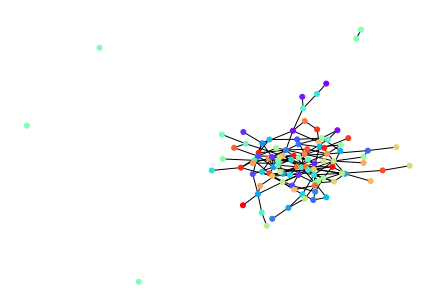

In [49]:
adj, labels= generate_SSBM(100, 2, 0.05, 0.03)
G=nx.from_numpy_matrix(adj)
part, *_ = weisfeiler_leman_partition(G)
nx.draw(G, node_size=25, node_color=part, cmap=cm.get_cmap("rainbow"), pos=nx.spring_layout(G))

Are SBMs just more likely to get cyclic, connected structure as opposed to CORA's slightly more treelike structure?

Process stabilized after 5 steps on a partition with 91 cells


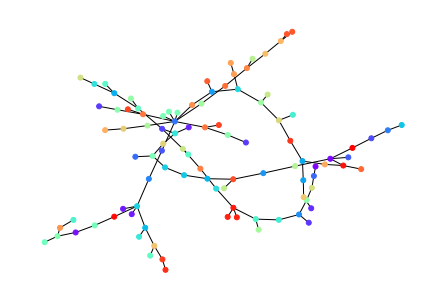

In [55]:
G = nx.random_tree(100)
part, *_ = weisfeiler_leman_partition(G)
nx.draw(G, node_size=25, node_color=part, cmap=cm.get_cmap("rainbow"), pos=nx.spring_layout(G))

Process stabilized after 3 steps on a partition with 98 cells


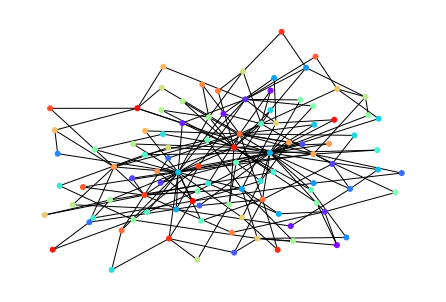

In [64]:
G = nx.barabasi_albert_graph(100, 2)
part, *_ = weisfeiler_leman_partition(G)
nx.draw(G, node_size=25, node_color=part, cmap=cm.get_cmap("rainbow"), pos=nx.spring_layout(G))